# To Do:
1. Check the method for future realized volatility / annualized daily volatility
2. Check the model code
3. Check the code for rolling forecasts
4. HIST & EMA Models explaination

In [1]:
import pandas as pd
import numpy as np
import math
import csv
import os
import os.path
import datetime
from datetime import datetime
import arch
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model

# File Import
### File Location and Description:
#### a. Minute: Single minute interval .CSV file (Dropbox Location: Dropbox/SSE_Options_YifeiZhang/IH510050_Time_Series.csv)
#### b. Daily: Single daily interval .CSV file (Dropbox Location: Dropbox/SSE_Options_YifeiZhang/IH510050_Daily_Time_Series.csv)

In [2]:
# Variable minute: Minute level price data for all 692 days in one single CSV file.
# Variable daily: Daily price data for all 692 days in one single CSV file.

minute = pd.read_csv('/Volumes/Liam_2/SSEO/H510050/SSEO_H510050_Price_Series_Final.csv')
daily = pd.read_csv('/Volumes/Liam_2/SSEO/H510050/SSEO_H510050_Daily.csv')

# Price and Return Series Generation

### 1. Minute Interval:
#### a. Price series summery: 2017-08-08 to 2020-06-12, 692 Trading days; 692*240 = 166080 Minutes
#### b. Return series summery: 2017-08-08 9:32 to 2020-06-12 15:30, 166079 Minutes

In [3]:
# Generate Minute Level Price Pandas Series: 
minute_price_list = minute['LastPrice'].tolist()
minute_datetime = minute['DateTime']
minute_datetime = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S") for d in minute_datetime]
minute_price = pd.Series(minute_price_list, index = minute_datetime)  # Length: 166080

# Generate Minute Level Return Pandas Series:
minute_return = minute_price.pct_change().dropna()  # Length: 166079

print(minute_price)
print()
print(minute_return)

2017-08-08 09:31:00    2.678
2017-08-08 09:31:57    2.677
2017-08-08 09:32:58    2.679
2017-08-08 09:33:56    2.678
2017-08-08 09:34:54    2.678
                       ...  
2020-06-12 14:56:00    2.876
2020-06-12 14:57:00    2.877
2020-06-12 14:58:00    2.890
2020-06-12 14:59:00    2.891
2020-06-12 15:00:00    2.889
Length: 166080, dtype: float64

2017-08-08 09:31:57   -0.000373
2017-08-08 09:32:58    0.000747
2017-08-08 09:33:56   -0.000373
2017-08-08 09:34:54    0.000000
2017-08-08 09:36:00    0.000000
                         ...   
2020-06-12 14:56:00    0.000000
2020-06-12 14:57:00    0.000348
2020-06-12 14:58:00    0.004519
2020-06-12 14:59:00    0.000346
2020-06-12 15:00:00   -0.000692
Length: 166079, dtype: float64


### 2. Daily Interval:
#### a. Price series summery: 2017-08-08 to 2020-06-12, 692 Trading days
#### b. Return series summery: 2017-08-09 to 2020-06-12, 691 Trading days

In [4]:
# Generate Daily Price Pandas Series:
daily_price_list = daily['LastPrice'].tolist()
daily_date = daily['Date']
daily_date = [datetime.strptime(d,"%Y-%m-%d").date() for d in daily_date]
daily_price = pd.Series(daily_price_list, index = daily_date)  # Length: 692

# Generate Daily Return Pandas Series:
daily_return = daily_price.pct_change().dropna()  # Length: 691

print(daily_price)
print()
print(daily_return)

2017-08-08    2.681
2017-08-09    2.664
2017-08-10    2.655
2017-08-11    2.612
2017-08-14    2.635
              ...  
2020-06-08    2.906
2020-06-09    2.923
2020-06-10    2.909
2020-06-11    2.878
2020-06-12    2.889
Length: 692, dtype: float64

2017-08-09   -0.006341
2017-08-10   -0.003378
2017-08-11   -0.016196
2017-08-14    0.008806
2017-08-15    0.006072
                ...   
2020-06-08    0.003800
2020-06-09    0.005850
2020-06-10   -0.004790
2020-06-11   -0.010657
2020-06-12    0.003822
Length: 691, dtype: float64


## Figure 1 - Daily Price, Return, Volatility

#### 1a. Daily Price - Daily Data

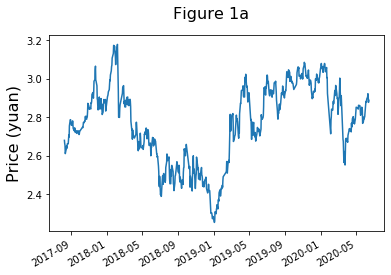

In [5]:
fig, ax = plt.subplots()
fig.suptitle('Figure 1a', fontsize=16)
plt.ylabel('Price (yuan)', fontsize=16)
ax.plot_date(daily_date, daily_price, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

#### 1b. Daily Return - Daily Data

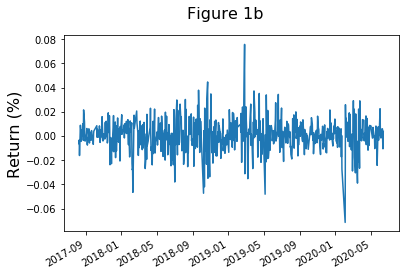

In [6]:
fig, ax = plt.subplots()
fig.suptitle('Figure 1b', fontsize=16)
plt.ylabel('Return (%)', fontsize=16)
ax.plot_date(daily_return.index, daily_return, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

#### 1c.  Annualized Daily Volatility - Minute Data
#### Data Source: 692 individual minute level .csv files (Dropbox Folder Path: Dropbox/SSE_Options_YifeiZhang/SSEO_H510050)

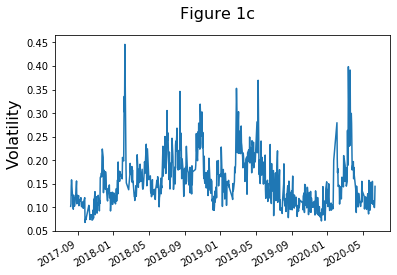

In [7]:
# Use single day's minute level data:
directory = os.listdir('/Volumes/Liam_2/SSEO/H510050/SSEO_H510050_Final')
directory.sort()

# Initiate variables
annualized_vol = []
file_date_list = []

# Iterate through every files in the folder, in total 692 (days)files
for file in directory:
    if file[0] != '.':  # Check for the right file name
        # Obtain date:
        file_date = file[8:-4]
        file_date = file_date[0:4] + '-' + file_date[4:6] + '-' + file_date[6:8]
        file_date_list.append(file_date)
        
        # Read price data of each file and produce daily annualized volatility:
        minute= pd.read_csv('/Volumes/Liam_2/SSEO/H510050/SSEO_H510050_Final/' + file, error_bad_lines = False)
        temp_daily_price = minute['LastPrice']
        temp_daily_return = temp_daily_price.pct_change().dropna()
        
        # Daily annualized volatility = sqrt(var(temp_daily_return)) * sqrt(252 yearly trading days * 240 daily trading minutes)
        annualized_daily_vol = math.sqrt(np.var(temp_daily_return)) * math.sqrt(252*240)
        annualized_vol.append(annualized_daily_vol)

# Create pandas series for annualized volatility data:
file_date = [datetime.strptime(d,"%Y-%m-%d").date() for d in file_date_list]
annualized_vol = pd.Series(annualized_vol, index = file_date) 

# Produce graph:
fig, ax = plt.subplots()
fig.suptitle('Figure 1c', fontsize=16)
plt.ylabel('Volatility', fontsize=16)
ax.plot_date(file_date, annualized_vol, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

## GARCH (1,1)

In [8]:
am = arch_model(daily_return, p = 1, q = 1, rescale=False) 
res = am.fit(update_freq=5) 
print(res.summary())

Iteration:      5,   Func. Count:     58,   Neg. LLF: -2071.71348324533
Iteration:     10,   Func. Count:    117,   Neg. LLF: -2073.0996761675688
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2073.1093319795878
            Iterations: 14
            Function evaluations: 141
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                2073.11
Distribution:                  Normal   AIC:                          -4138.22
Method:            Maximum Likelihood   BIC:                          -4120.07
                                        No. Observations:                  691
Date:                Tue, Aug 18 2020   Df Residuals:                      687
Time:    

### Rolling Forecast

In [9]:
# Initiate list:
garch_rolling_predictions = []

# Specify test size: 692 - 245(trading days of the first year, from 17-08-08 to 18-08-07) = 447 (produce forecast on days from 18/08/08 - 20/06/12)
test_size = 447

# Rolling forecast:
for i in range(test_size):
    data_set = daily_return[:-(test_size-i)]
    model = arch_model(data_set, p=1, q=1, rescale=False) # GARCH(1,1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1) # Produce T+1 forecasts
    garch_rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]) * math.sqrt(252))  # Produce annualized volatility
    
garch_rolling_predictions = pd.Series(garch_rolling_predictions, index=daily_date[-447:])







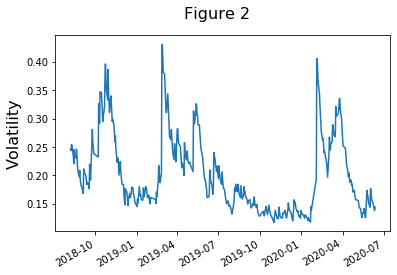

In [10]:
fig, ax = plt.subplots()
fig.suptitle('Figure 2', fontsize=16)
plt.ylabel('Volatility', fontsize=16)
ax.plot_date(daily_date[-447:], garch_rolling_predictions, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

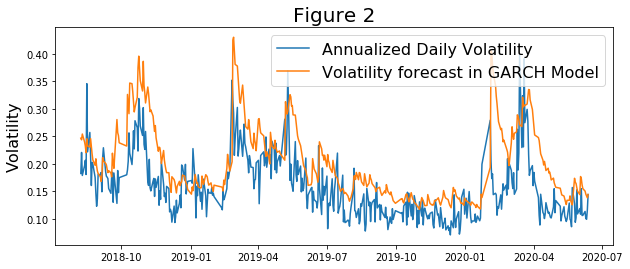

In [11]:
plt.figure(figsize=(10,4))
true, = plt.plot(annualized_vol[-447:])
preds, = plt.plot(garch_rolling_predictions)
plt.title('Figure 2', fontsize=20)
plt.ylabel('Volatility', fontsize=16)
plt.legend(['Annualized Daily Volatility', 'Volatility forecast in GARCH Model'], fontsize=16)

## ARCH (1,0)

In [12]:
am = arch_model(daily_return, p=1, q=0, rescale=False) 
res = am.fit(update_freq=5) 
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2024.7728371554163
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:                2024.77
Distribution:                  Normal   AIC:                          -4043.55
Method:            Maximum Likelihood   BIC:                          -4029.93
                                        No. Observations:                  691
Date:                Tue, Aug 18 2020   Df Residuals:                      688
Time:                        11:45:40   Df Model:                            3
                                  Mean Model                                 
 

### Rolling Forecast

In [13]:
# Initiate list:
arch_rolling_predictions = []

# Specify test size: 692 - 245(trading days of the first year, from 17-08-08 to 18-08-07) = 447 (produce forecast on days from 18/08/08 - 20/06/12)
test_size = 447

# Rolling forecast:
for i in range(test_size):
    data_set = daily_return[:-(test_size-i)]
    model = arch_model(data_set, p=1, q=0, rescale=False) # ARCH(1,0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1) # Produce T+1 forecasts
    arch_rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]) * math.sqrt(252))  # Produce annualized volatility
    
arch_rolling_predictions = pd.Series(arch_rolling_predictions, index=daily_date[-447:])

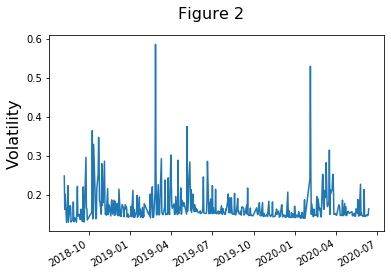

In [14]:
fig, ax = plt.subplots()
fig.suptitle('Figure 2', fontsize=16)
plt.ylabel('Volatility', fontsize=16)
ax.plot_date(daily_date[-447:], arch_rolling_predictions, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

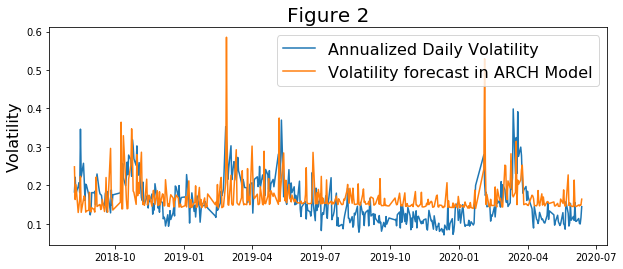

In [15]:
plt.figure(figsize=(10,4))
true, = plt.plot(annualized_vol[-447:])
preds, = plt.plot(arch_rolling_predictions)
plt.title('Figure 2', fontsize=20)
plt.ylabel('Volatility', fontsize=16)
plt.legend(['Annualized Daily Volatility', 'Volatility forecast in ARCH Model'], fontsize=16)

## EGARCH (1,1)

In [16]:
am = arch_model(daily_return, vol='egarch', p=1, q=1, rescale=False) 
res = am.fit(update_freq=5) 
print(res.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: -2071.5266240449882
Iteration:     10,   Func. Count:     78,   Neg. LLF: -2072.9037725132816
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2072.9043232468475
            Iterations: 13
            Function evaluations: 96
            Gradient evaluations: 13
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                     EGARCH   Log-Likelihood:                2072.90
Distribution:                  Normal   AIC:                          -4137.81
Method:            Maximum Likelihood   BIC:                          -4119.66
                                        No. Observations:                  691
Date:                Tue, Aug 18 2020   Df Residuals:                      687
Time:   

### Rolling Forecast

In [17]:
# Initiate list:
egarch_rolling_predictions = []

# Specify test size: 692 - 245(trading days of the first year, from 17-08-08 to 18-08-07) = 447 (produce forecast on days from 18/08/08 - 20/06/12)
test_size = 447

# Rolling forecast:
for i in range(test_size):
    data_set = daily_return[:-(test_size-i)]
    #print(data_set)
    model = arch_model(data_set, vol='egarch', p=1, q=1, rescale=False)  # EGARCH(1,1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)  # Produce T+1 forecasts
    egarch_rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]) * math.sqrt(252))
    
egarch_rolling_predictions = pd.Series(egarch_rolling_predictions, index=daily_date[-447:])

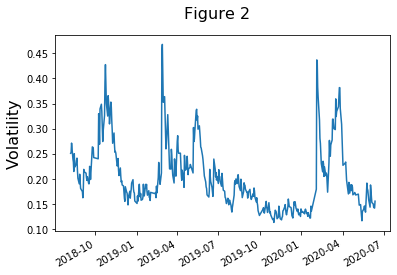

In [18]:
fig, ax = plt.subplots()
fig.suptitle('Figure 2', fontsize=16)
plt.ylabel('Volatility', fontsize=16)
ax.plot_date(daily_date[-447:], egarch_rolling_predictions, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

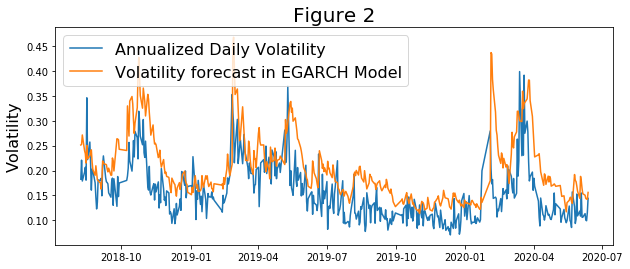

In [19]:
plt.figure(figsize=(10,4))
true, = plt.plot(annualized_vol[-447:])
preds, = plt.plot(egarch_rolling_predictions)
plt.title('Figure 2', fontsize=20)
plt.ylabel('Volatility', fontsize=16)
plt.legend(['Annualized Daily Volatility', 'Volatility forecast in EGARCH Model'], fontsize=16)